# Regressão Linear

### Configurações

A célula abaixo define funções que iremos usar para exibir nossos dados. Você pode ignorá-la. (Mas lembre-se de executar)

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_class_points(class_1, class_2, y_values = None):

    plt.figure(figsize=(6, 4)) # Define uma figura com as dimensões 6cmx4cm
    plt.scatter(class_1[:, 0], class_1[:, 1], color='blue', label='Classe 1') # Plota o conjunto de pontos da classe 1
    plt.scatter(class_2[:, 0], class_2[:, 1], color='red', label='Classe 2') # Plota o conjunto de pontos da classe 2

    if y_values is not None:
        plt.plot(np.linspace(-4, 4, 100), y_values, color='green', label='Reta') # Plota uma lina entre x=-4 e x=4 com os valores especificados em y_values


    # Configurações do gráfico
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Pontos Linearmente Separáveis em um Plano 2D')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_points(x, y, y_hat = None):


    # Plotar os dados
    plt.scatter(x, y, color='blue', label='Pontos de Dados')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Conjunto de Dados para Regressão Linear')
    plt.legend()
    plt.grid(True)

    if y_hat is not None:
        plt.plot(np.linspace(0, x.max(), 100), y_hat, color='green', label='Reta')

    plt.show()

def generate_rgt():

    np.random.seed(27) # Setando uma seed aleatória para gerarmos sempre o mesmo rgt.


    width, height = 128, 192  # Dimensões da imagem (largura x altura)
    image = np.zeros((height, width)) # Matriz vazia para armazenar o rgt.

    # 1. Gerando horizontes aleatórios completamente retos.
    num_lines = 16  # Número de linhas horizontais iniciais
    line_positions = np.sort(np.random.choice(height, num_lines, replace=False))
    line_values = np.abs(np.arange(-num_lines, 0))  # Valores crescentes para cada linha

    

    # 2. Aplicar deformações para curvar os horizontes.
    for i, pos in enumerate(line_positions):
        curve = (torch.sin(torch.linspace(0, np.pi * 2, width)) * 7).int()  # Curva de seno
        curved_line = pos + curve  # Aplicar curva na posição da linha

        # Garantir que a linha curva esteja dentro dos limites da imagem
        curved_line = torch.clamp(curved_line, 0, height - 1)

        # Aplicar os valores das linhas curvadas na imagem
        for x in range(width):
            image[curved_line[x], x] = line_values[i]

    # 3. Interpolar linearmente entre os horizontes para preencher os valores do rgt
    for x in range(width):
        # Obter os valores não zero na coluna x
        y_vals = np.where(image[:, x] > 0)[0]
        if len(y_vals) > 1:
            f_interp = interp1d(y_vals, image[y_vals, x], kind='linear', fill_value="extrapolate")
            image[:, x] = f_interp(np.arange(height))

    # Dividindo o rgt em duas imagens com overlap de 64.
    rgt1 = image[:128, :]
    rgt2 = image[64:, :]
    # Normalizando o rgt
    rgt1 = rgt1 - rgt1.min()
    rgt1 = rgt1 / rgt1.max()
    rgt2 = rgt2 - rgt2.min()
    rgt2 = rgt2 / rgt2.max()

    return torch.tensor(rgt1), torch.tensor(rgt2)

def show_rgt(rgt):

    plt.imshow(rgt, cmap="magma_r", origin="lower", aspect='auto') # Mostra uma imagem
    plt.title("RGT Sintético 1")
    plt.colorbar(label="Intensidade")
    plt.show()

def show_rgts(rgt1, rgt2):
    plt.figure(figsize=(12, 4)) 

    # Exibir o primeiro RGT
    plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, posição 1
    plt.imshow(rgt1, cmap="magma_r", origin="lower", aspect='auto')
    plt.title("RGT Sintético 1")
    plt.colorbar(label="Intensidade")

    # Exibir o segundo RGT
    plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, posição 2
    plt.imshow(rgt2, cmap="magma_r", origin="lower", aspect='auto')
    plt.title("RGT Sintético 2")
    plt.colorbar(label="Intensidade")

    plt.show()

## Introdução

Na aula de hoje iremos entender melhor como as regressões lineares funcionam na prática. Para isso, nós iremos usar o pytorch e a computação diferenciável para fazer uma regressão do zero. Implementações deste método  (e de quase todas as técnicas clássicas de aprendizado de máquina) já foram feitas em bibliotecas como o scikit-learn, e, no dia-a-dia, seu uso é certamente mais prático do que fazer tudo você mesmo! Para mais informações, consulte a documentação do sklearn:

https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LinearRegression.html

Objetivos:

- Entender como funciona uma regressão linear.
- Aplicar uma regressão linear em tarefas de classificação e regressão.
- Ver uma aplicação prática de regressão linear na geologia.
- Extender regressões lineares para dados não lineares por meio de features polinomiais.


A regressão linear é um método clássico de aprendizado de máquina que nos possibilita estimar algum valor dado um conjunto de varáveis de entrada. Em uma regressão linear simples, temos uma variável de entrada (ou feature), que chamamos de
𝑥, e um valor que queremos prever (ou target), que chamamos de
𝑦.

O objetivo da regressão linear é encontrar uma reta que melhor se ajusta aos dados, de forma que possamos usar essa reta para fazer previsões sobre novos valores.



>Relembrando a equação de uma reta:
>
>$$
y = w \cdot x + b
$$
>onde:
>
>- 𝑤 é o coeficiente ou peso da variável 𝑥 e ele determina a inclinação da linha.
>- 𝑏 é o intercepto (ou bias), que representa o ponto onde a linha intercepta o eixo 𝑦 quando $𝑥=0$.

## Exercício 1: Criando uma reta

O código abaixo define dois conjuntos de pontos, os azuis e os vermelhos.

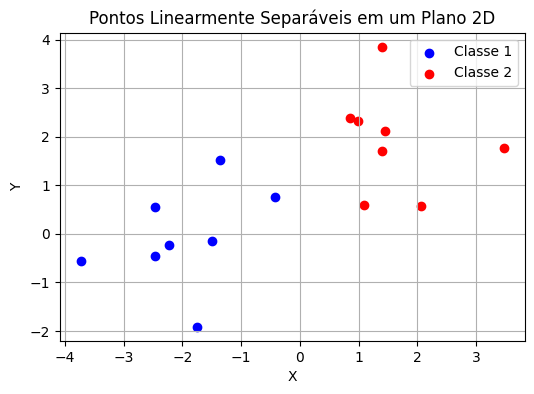

In [2]:
import numpy as np

# Configurar a semente para reprodutibilidade
np.random.seed(42)

# Criando nossos pontos
azul = np.random.randn(8, 2) + np.array([-2, 0])
vermelho = np.random.randn(8, 2) + np.array([2, 2])

plot_class_points(azul, vermelho) # Função de exibir os pontos definida mais acima

Usando numpy defina uma reta que separe os dois cojuntos de pontos

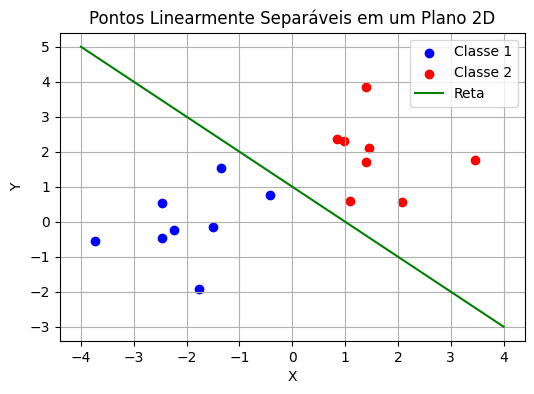

In [3]:
def reta(x):
    w = -1
    b = 1
    y = w*x + b
    return y

x_values = np.linspace(-4, 4, 100) # Definindo os valores válidos de x
y_values = reta(x_values) # Definindo os valores de y para cada x
plot_class_points(azul, vermelho, y_values=y_values)


## Exercício 2: Encontrando a reta

Para encontrar a melhor linha, precisamos determinar os valores de $w$ e $b$ que minimizam a diferença entre as previsões $\hat{y}$ e os valores reais $y$. Essa diferença é chamada de **erro**. Em regressão linear, usamos uma medida de erro chamada de **erro quadrático médio** (ou MSE, do inglês *Mean Squared Error*):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2
$$

onde:
- $N$ é o número de pontos nos dados,
- $y_i$ é o valor real da variável dependente para o ponto $i$,
- $\hat{y}_i$ é o valor predito pelo modelo para o ponto $i$.


### a. Classificação


No nosso caso, temos uma tarefa de *Classificação*.

> Em uma tarefa de classificação, queremos separar nossos dados em grupos *conhecidos*. Nesse caso, temos dois grupos: pontos azuis e vermelhos.

Assim, atribuíremos um valor numérico a cada classe (azul: -1, vermelho: 1) e usaremos eles para calcular o nosso erro.

>obs: Na prática, para tarefas de classificação, outras funções de perda são mais adequadas (como a entropia cruzada). Estudaremos elas em aulas seguintes.

**Agora é com você!**  Usando pytorch, faça um modelo de regressão linear que encontre a reta que separa os pontos azuis dos vermelhos


In [4]:
import torch

## Antes de mais nada, vamos converter passar nossos pontos para o pytorch
azul = torch.tensor(azul).float() # convertemos o tensor para float para evitar conflitos
vermelho = torch.tensor(vermelho).float()

## Agora, vamos criar um único vetor, X, que contém todos os pontos
X = torch.cat([azul, vermelho]).float()

## Por fim, vamos criar o vetor de respostas, y.
## Note que pontos azuis correspondem a y=-1, e vermelhos a y=1
y = torch.cat([torch.zeros(len(azul)) - 1, torch.ones(len(vermelho))]).float()

In [5]:

w = torch.randn(2, requires_grad=True)
bias = torch.randn(1, requires_grad=True)

def model(X, w, bias):
    # Fazemos um produto matricial entre X e w.
    # Shape de X: [n_entradas, n_features]
    # Shape de w: [n_features, 1] (ou simplesmente [n_features,])
    # Shape do Resultado [n_entradas, 1] (ou [n_entradas,])
    # Desenvolvendo esse produto, vemos facilmente que ele é equivalente a:
    #           x1w1 + x2w2 + ... + xnwn

    return X @ w + bias 

def mse_loss(y_pred, y_true):
    # Calcula o erro quadrático médio entre as predições e os valores reais.
    return ((y_pred - y_true) ** 2).mean()

def train(X, y, w, bias, num_epochs, learning_rate):


    for epoch in range(num_epochs):
        y_pred = model(X, w, bias) # Extraindo a previsão do modelo para nossos dados.
        loss = mse_loss(y_pred, y) # Calculando o MSE entre a predição e nossas labels.
        loss.backward() # Calculando os gradientes de nosso modelo.

        with torch.no_grad(): # Usamos no_grad para que os calculos a seguir não entrem no próximo calculo de gradientes.
            # Ajustando os valores com base nos gradientes.
            w -= learning_rate * w.grad # Note que w.grad e bias.grad vieram da chamada de backward.
            bias -= learning_rate * bias.grad
            

        # Zerando o gradiente para a próxima iteração.
        w.grad.zero_() 
        bias.grad.zero_()

        if (epoch + 1) % (num_epochs/10) == 0:
            print(f'Época {epoch+1}, Perda: {loss.item():.4f}')

train(X, y, w, bias, 500, 0.01)

Época 50, Perda: 1.1147
Época 100, Perda: 0.5748
Época 150, Perda: 0.3644
Época 200, Perda: 0.2627
Época 250, Perda: 0.2133
Época 300, Perda: 0.1893
Época 350, Perda: 0.1776
Época 400, Perda: 0.1719
Época 450, Perda: 0.1692
Época 500, Perda: 0.1678


Pronto! O modelo acima aprendeu a separar os pontos azuis dos vermelhos. Como? Simples, caso o modelo veja um ponto azul, ele retornará um valor negativo, e caso veja um ponto vermelho, retornará um valor positivo.

 Vamos verificar se deu certo?

In [6]:
pred_azuis = model(azul, w, bias) # Usando nosso modelo para prever os pontos azuis.

# O código abaixo verifica se todas nossas predições estão corretas, isto é, se elas foram números negativos.
assert torch.all(pred_azuis < 0), "Ops, parece que alguns pontos azuis foram classificados como vermelhos"

pred_azuis.detach() # Usamos .detach() para remover os gradientes dos nossos tensores.

tensor([-0.6256, -0.3896, -0.9337, -0.0891, -0.9481, -1.0515, -0.9158, -1.5761])

In [7]:
pred_vermelhos = model(vermelho, w, bias)
assert torch.all(pred_vermelhos > 0), "Ops, parece que alguns pontos vermelhos foram classificados como azuis"
pred_vermelhos.detach()

tensor([0.6475, 0.5090, 1.6015, 0.9055, 0.8172, 0.5976, 0.7520, 0.9766])

#### Desafio!

Encontre a reta definida pelo nosso modelo.
> Dica: podemos definir nossa regressão pela fórmula:
> $$pred=w_0x + w_1y + b$$
> Para encontrar a reta, encontre os valores para os quais pred = 0.

In [8]:
w = w.detach()
bias = bias.detach()

# y = -(w0 / w1)x - w1b
y_values = -w[0]/w[1]*x_values - bias.item()/w[1]

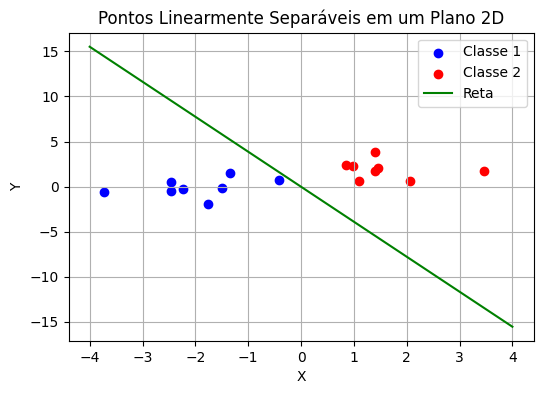

In [9]:
plot_class_points(azul, vermelho, y_values=y_values)

Note que a reta não exatamente igual à que você definiu manualmente... Mas não tem problema! Existem infinitas retas que dividem esses dois conjuntos de pontos.

### Regressão

Podemos também usar uma regressão linear para encontrar a reta que melhor representa um conjunto de pontos. Para isso, um processo parecido com o anterior, mas agora nosso modelo receberá uma úncia entrada, x, e tentará prever y.

O código abaixo gera um conjunto de pontos para usarmos de exemplo.

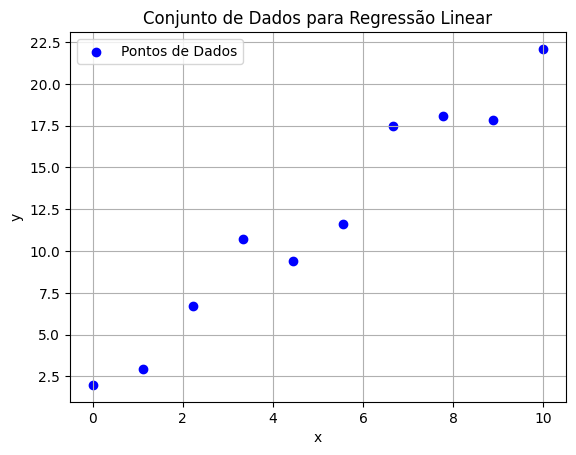

In [10]:
# Configurar a semente para reprodutibilidade
np.random.seed(42)

# Gerar 10 valores para a variável independente x entre 0 e 10
x = np.linspace(0, 10, 10)

# Definir a relação linear verdadeira entre x e y: y = 2x + 1
# Adicionar algum ruído gaussiano para tornar os dados mais realistas
y = 2 * x + 1 + np.random.normal(0, 2, size=x.shape)

plot_points(x, y) # Função definida mais acima



Faça uma regressão linear para encontrar a reta que melhor aproxima esse conjunto de pontos. Use a função train, definida no exercício anterior.

> dica: Use X.unsqueeze(1) para adicionar uma dimensão a mais no seu vetor X. Verifique o shape de X antes e depois da operação.

In [11]:
## Faça aqui
X = torch.tensor(x).float().unsqueeze(1)
y = torch.tensor(y).float()

w = torch.randn(1, requires_grad=True)
bias = torch.randn(1, requires_grad=True)

train(X, y, w, bias, 500, 0.01) # Você pode brincar com os valores de num_epoch e learning_rate, mas estes devem funcionar bem.

Época 50, Perda: 2.1896
Época 100, Perda: 2.0554
Época 150, Perda: 1.9794
Época 200, Perda: 1.9364
Época 250, Perda: 1.9121
Época 300, Perda: 1.8983
Época 350, Perda: 1.8905
Época 400, Perda: 1.8861
Época 450, Perda: 1.8836
Época 500, Perda: 1.8821


Agora vamos plotar a reta para verificar se nosso modelo está correto.

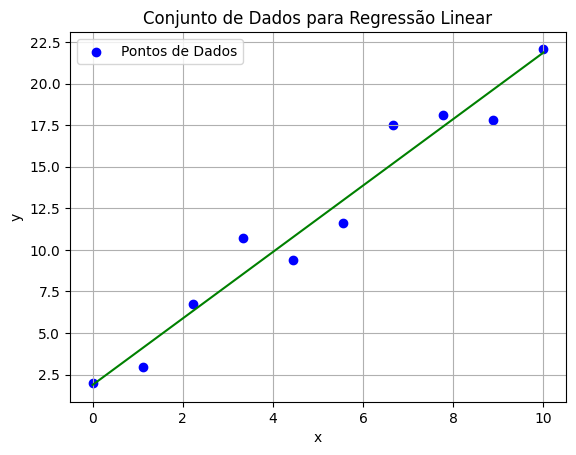

In [12]:

plot_x = np.linspace(0, 10, 100)
plot_x = torch.tensor(plot_x).unsqueeze(1).float()
y_hat = model(plot_x, w, bias).detach().numpy()

plot_points(x, y, y_hat)

## Desafio: Regressão e RGT

O tempo geológico relativo(RGT) é uma medida *relativa* da idade de algum elemento geológico. Uma tarefa comum na geologia é, dada uma imagem sísmica, tentar estimar o RGT de cada píxel da imagem.

Como não temos uma escala absoluta de comparação, podemos representar o rgt de uma imagem como um valor entre 0 e 1, tal que, quanto maior o valor de um píxel, mais antigo ele é.

### Concatenação

Como a predição de RGT é uma tarefa altamente complexa, é comum que treinemos um grande modelo de aprendizado profundo para estimar o RGT de uma sísmica. Esses modelos, no entanto, tem um grande problema: devido ao grande tamanho das sísmicas, não é possível passá-las inteiramente para a nossa rede.

Para resolver isso, nós dividimos a sísmica em diversas regiões menores. O código abaixo simula isso, gerando 2 previsões sintéticas de um modelo de RGT.. Geográficamente, rgt1 está em cima de rgt 2.

> obs: Note que as imagens geradas tem uma interseção (ou overlap) de 64 pixeis. Ou seja, a primeira metade de rgt2 é igual a primeira metade de rgt1.

In [13]:
rgt1, rgt2 = generate_rgt() # Gerando um rgt sintético. Função definida mais acima.

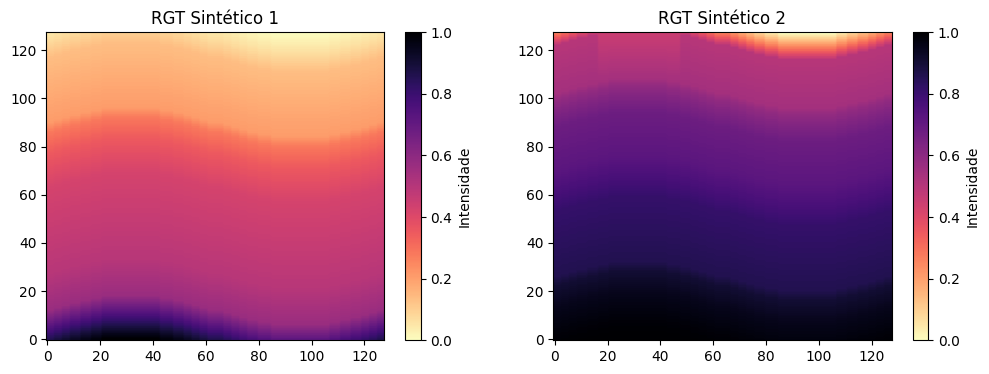

In [14]:
show_rgts(rgt1, rgt2) # Função definida mais acima.

Como queremos observar o rgt completo de nossa sísmica, precisamos juntar essas duas images. Use a função torch.cat para concatenar os 2 rgts.
> dica: lembre-se que que existe um overlap de 64 píexeis entre as duas imagens. O formato final da saída deve ser (192x128)

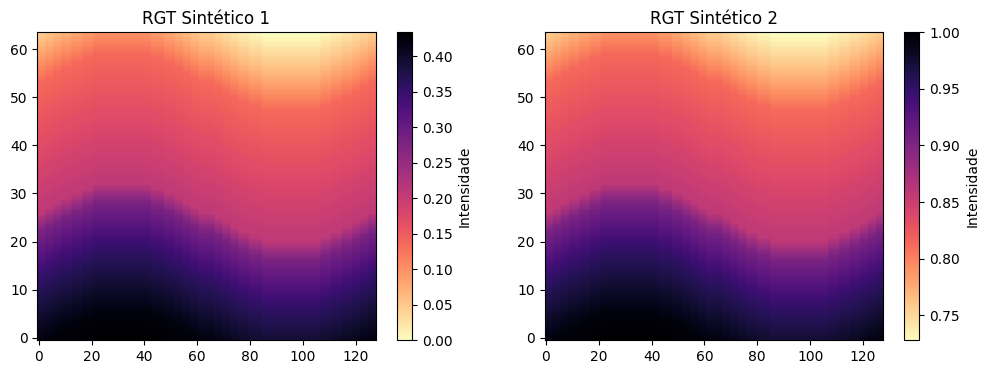

In [15]:
# Note que a região de overlap é exatamente igual (com excessão dos valores)
show_rgts(rgt1[64:], rgt2[:64])

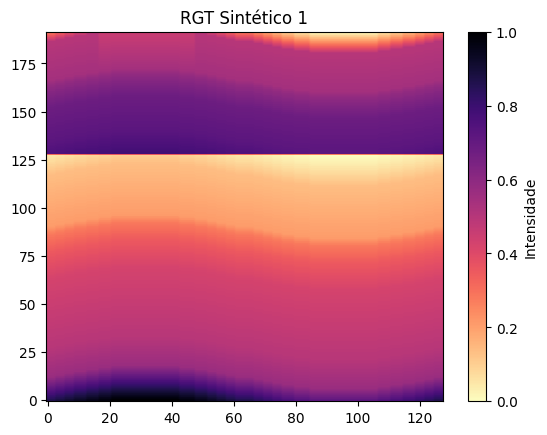

In [16]:
rgt_concat = torch.cat([rgt1, rgt2[64:]], dim = 0)
show_rgt(rgt_concat)

Parece que esse método simples não funciona... Mas Por que?

Como o RGT está em uma escala relativa, píxeis com o mesmo valor em 2 imagens diferentes não representam a mesma idade. Em rgt2, por exemplo, um píxel com valor de 0.5 pode representar uma região com idade de 10M anos, enquanto essa mesma idade em rgt1 seria o valor 0.9.

Para resolver esse problema, nós precisamos estabelecer uma releção entre os valores de rgt1 e rgt2.

Usando pytroch, faça uma regressão linear que encontre a relação entre rgt1 e rgt2 e concatena as duas imagens. Ao final do exercício, a divisão entre rgt1 e rgt2 deve ser imperceptível.

> Dica: Considerando **apenas a região de overlap**, use os valores de rgt1 como X e de rgt2 como y.

In [17]:
## Faça aqui
X = rgt1[64:].flatten().float().unsqueeze(1)
y = rgt2[:64].flatten().float()

w = torch.randn(1, requires_grad=True)
bias = torch.randn(1, requires_grad=True)


# Dica: essa tarefa é um pouco mais difícil, tenta aumentar o número de epochs.
train(X, y, w, bias, 20000, 0.01)

Época 2000, Perda: 0.0009
Época 4000, Perda: 0.0004
Época 6000, Perda: 0.0001
Época 8000, Perda: 0.0001
Época 10000, Perda: 0.0000
Época 12000, Perda: 0.0000
Época 14000, Perda: 0.0000
Época 16000, Perda: 0.0000
Época 18000, Perda: 0.0000
Época 20000, Perda: 0.0000


In [18]:
rgt1 = model(rgt1.float().unsqueeze(2), w, bias)

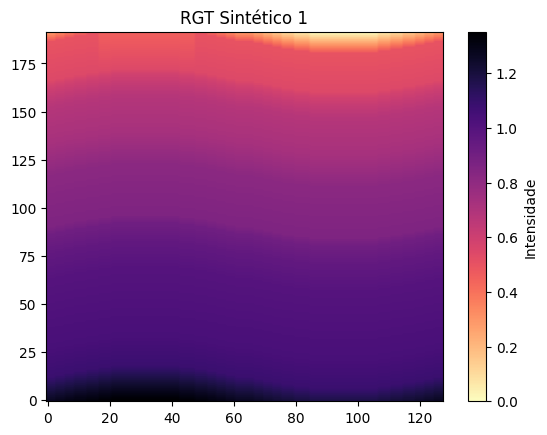

In [19]:
rgt1 = rgt1.detach()
rgt2 = rgt2.detach()

rgt_concat = torch.cat([rgt1[:64], rgt2], dim = 0)
show_rgt(rgt_concat)

## Exercício 3: Dados não-lineares

Até aqui, todos os exercícios tinham como uma solução uma equação linear. Isso, no entanto, nem sempre é possível.

O código abaixo gera um conjunto de pontos não linear.

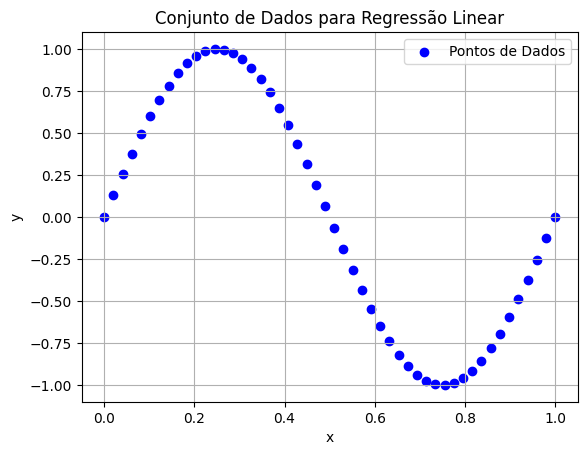

In [20]:
x_range = np.linspace(0, 1, 50)
sin_x = np.sin(x_range * 2 * np.pi)
plot_points(x_range, sin_x)

Usando uma regressão linear, encontre a reta que melhor representa esses pontos.

In [21]:
## Faça aqui
X = torch.tensor(x_range).float().unsqueeze(1)
y = torch.tensor(sin_x)

w = torch.randn(1, requires_grad=True)
bias = torch.randn(1, requires_grad=True)


# Dica: essa tarefa é um pouco mais difícil, tenta aumentar o número de epochs.
train(X, y, w, bias, 1000, 0.01)

Época 100, Perda: 0.3093
Época 200, Perda: 0.2624
Época 300, Perda: 0.2498
Época 400, Perda: 0.2403
Época 500, Perda: 0.2331
Época 600, Perda: 0.2277
Época 700, Perda: 0.2235
Época 800, Perda: 0.2203
Época 900, Perda: 0.2179
Época 1000, Perda: 0.2161


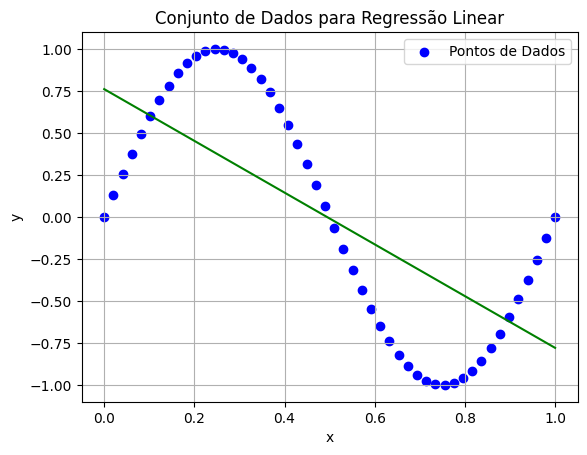

In [22]:
plot_x = np.linspace(0, 1, 100)
plot_x = torch.tensor(plot_x).unsqueeze(1).float()
y_hat = model(plot_x, w, bias).detach().numpy()

plot_points(x_range, sin_x, y_hat)

Parece que nossa reta não captura muito bem os dados. O que podemos fazer para resolver esse problema? Bom, precisamos de pensar em algum jeito de introduzir uma não-linearidade em nossa regressão

Uma das formas mais comuns de introduzir não linearidade em uma regressão linear é utilizando features polinomiais. Em vez de modelar apenas uma relação linear entre $x$ e $y$ podemos incluir potências de $x$ como features adicionais. Por exemplo, ao adicionar termos quadráticos e cúbicos, estamos transformando nosso modelo linear em um polinômio:

$$y = w_0 + w_1x + w_2x^2 + ... + w_dx^d$$

onde d é o grau máximo do polinômio que queremos incluir.

Essas features polinomiais permitem que o modelo capture relações não lineares nos dados, mantendo a simplicidade e a interpretabilidade de um modelo linear nos parâmetros.

Usando features não lineares, ache um modelo que aproxime bem a função seno. O que acontece quando aumentamos o valor de d?

In [23]:
def create_polynomial_features(X, degree):
    X_poly = X # Inicializando nossas featurese com x^1
    for d in range(2, degree + 1):
        X_poly = torch.cat((X_poly, X**d), dim=1) # Adicionando x^d às features.
    return X_poly

X = torch.tensor(x_range).float().unsqueeze(1)
y = torch.tensor(sin_x)

degree = 10  # Exemplo: grau polinomial
X_poly = create_polynomial_features(X, degree)  # Expandir as features para o grau desejado

# Inicializar pesos e bias para o modelo polinomial
w = torch.randn(degree, requires_grad=True)  # O peso precisa ter a mesma quantidade de features do modelo
bias = torch.randn(1, requires_grad=True)

train(X_poly, y, w, bias, num_epochs=10000, learning_rate=0.01) # Agora passamos x_poly para o modelo.

Época 1000, Perda: 0.2365
Época 2000, Perda: 0.1619
Época 3000, Perda: 0.1421
Época 4000, Perda: 0.1325
Época 5000, Perda: 0.1254
Época 6000, Perda: 0.1194
Época 7000, Perda: 0.1141
Época 8000, Perda: 0.1095
Época 9000, Perda: 0.1053
Época 10000, Perda: 0.1017


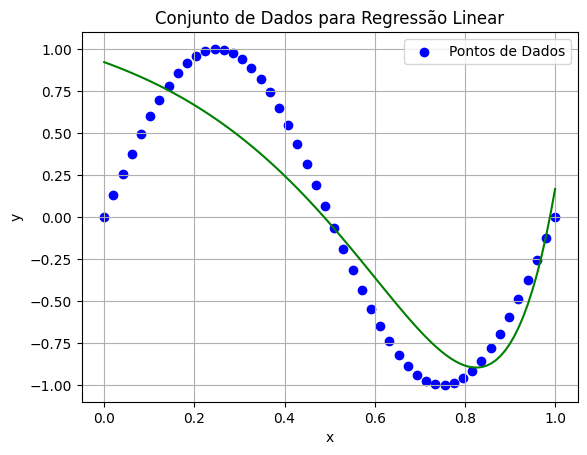

In [24]:
plot_x = np.linspace(0, 1, 100)
plot_x = torch.tensor(plot_x).unsqueeze(1).float()
X_poly = create_polynomial_features(plot_x, degree)
y_hat = model(X_poly, w, bias).detach().numpy()

plot_points(x_range, sin_x, y_hat)

No geral, aumentar o grau do nosso polinômio melhora a qualidade do nosso modelo. Porém cuidado, um grau muito alto pode resultar em compartamentos estranhos. A figura abaixo mostra um modelo com d=5000.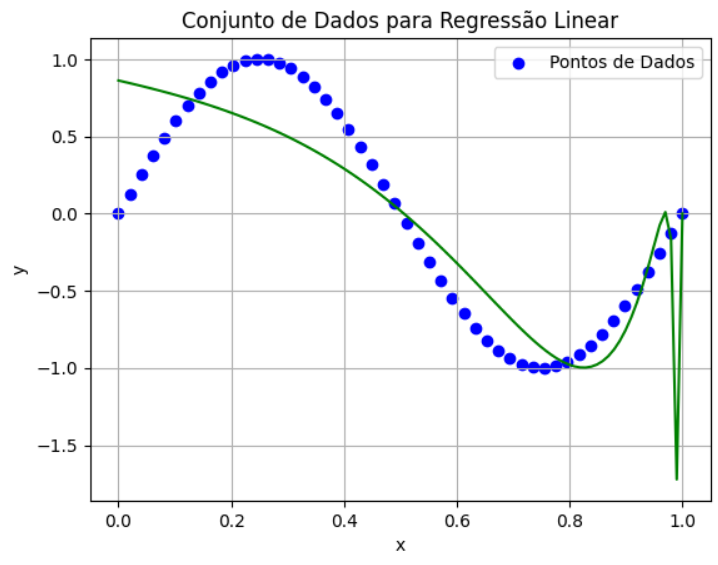

Mesmo parecendo estranho, repare que a linha verde ainda captura quase que perfeitamente os dois últimos pontos azuis. O modelo, portanto, encontrou uma representação que se encaixa bem com os dados que ele viu ao longo do treino, mas certamente isso não generalizaria bem para novos dados!

 Nós chamamos esse tipo de erro de *overfitting*, e ele será discutido em detalhes ao longo do curso.